In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
df = pd.read_csv("/content/911_metadata.csv")
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (710, 13)
   id  event_id                                               link  \
0   0         2  https://web.archive.org/web/20150417085342/htt...   
1   1         8  https://web.archive.org/web/20150417085342/htt...   
2   2         9  https://web.archive.org/web/20150417085342/htt...   
3   3        10  https://web.archive.org/web/20150417085342/htt...   
4   4        11  https://web.archive.org/web/20150417085342/htt...   

                              title  date     state  deaths  potential_death  \
0  Detroit Child’s 911 Call – audio  2/06  Michigan     1.0              1.0   
1            Girl’s Murder 911 Call  3/05   Florida     2.0              1.0   
2             ‘Shoot Her?’ 911 call  4/05     Texas     0.0              0.0   
3                Snowstorm 911 Call  1/05  Nebraska     2.0              1.0   
4               911 Call for a Date  1/06    Oregon     0.0              0.0   

   false_alarm                                        description  \
0   

In [ ]:
def extract_category(text):
    """Extracts category from title text safely."""
    if isinstance(text, str) and ":" in text:
        return text.split(":")[0].strip()
    elif isinstance(text, str):
        if "Fire" in text: return "Fire"
        elif "Traffic" in text: return "Traffic"
        elif "EMS" in text: return "EMS"
        else: return "Other"
    else:
        return "Other"

df["Category"] = df["title"].apply(extract_category)
df = df[df["Category"].notna() & (df["Category"] != "Unknown")]

print("\n🔹 Category distribution:")
print(df["Category"].value_counts())


🔹 Category distribution:
Category
Other      699
Fire         9
EMS          1
Traffic      1
Name: count, dtype: int64


In [ ]:
if "desc" in df.columns:
    df["Text"] = df["title"].astype(str) + " " + df["desc"].astype(str)
else:
    df["Text"] = df["title"].astype(str)

In [ ]:
X = df["Text"]
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\n✅ Data split complete.")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


✅ Data split complete.
Train samples: 566, Test samples: 142


In [ ]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=200, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })


🚀 Training Naive Bayes...

🚀 Training Logistic Regression...

🚀 Training Random Forest...


In [ ]:
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\n🏆 Model Performance Comparison:")
print(results_df.round(4))


🏆 Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score
2        Random Forest    0.9930      0.993  0.9930    0.9918
0          Naive Bayes    0.9859      0.972  0.9859    0.9789
1  Logistic Regression    0.9859      0.972  0.9859    0.9789


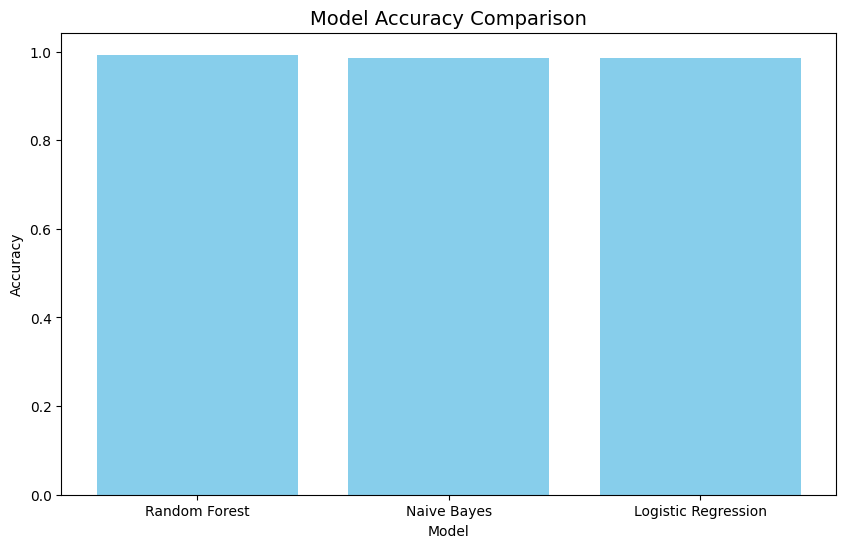

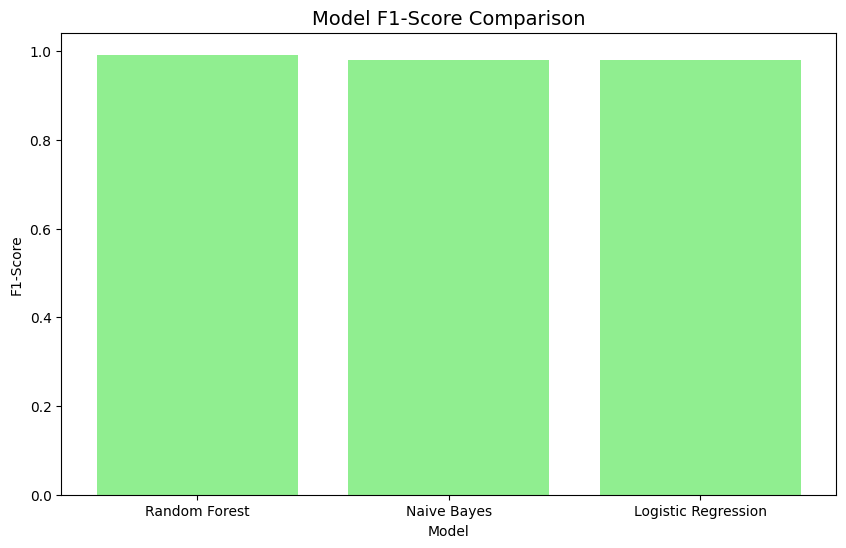

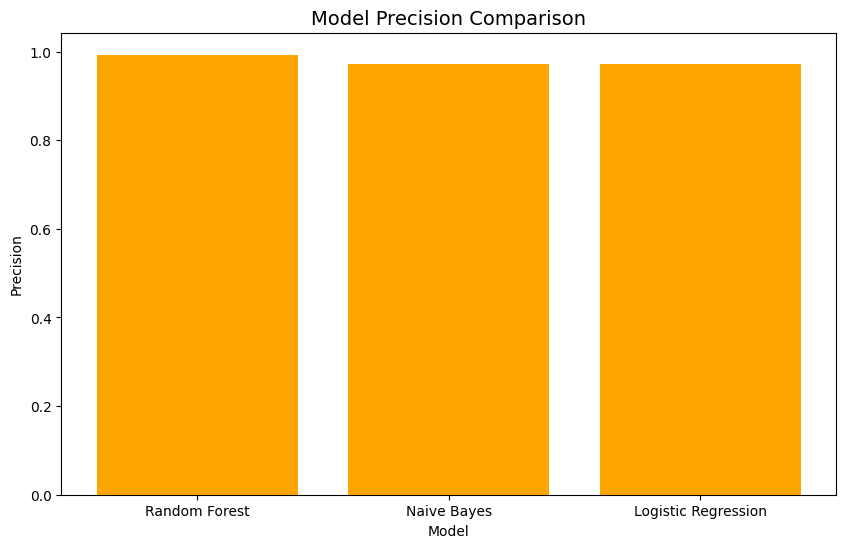

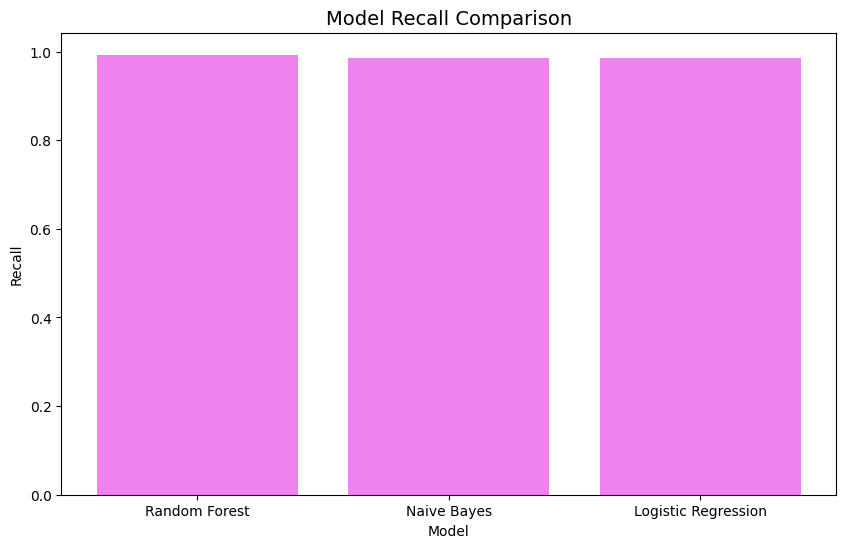

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["Accuracy"], color='skyblue')
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["F1-Score"], color='lightgreen')
plt.title("Model F1-Score Comparison", fontsize=14)
plt.xlabel("Model")
plt.ylabel("F1-Score")
plt.show()

plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["Precision"], color='orange')
plt.title("Model Precision Comparison", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Precision")
plt.show()

plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["Recall"], color='violet')
plt.title("Model Recall Comparison", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Recall")
plt.show()

In [ ]:
import joblib
import os

# Create a folder to save models
os.makedirs("saved_models", exist_ok=True)

# Save each trained model
for name, model in models.items():
    filename = f"saved_models/{name.replace(' ', '_').lower()}.joblib"
    joblib.dump(model, filename)
    print(f"✅ Saved {name} → {filename}")

# Save the TF-IDF vectorizer too (needed for new data later)
joblib.dump(vectorizer, "saved_models/tfidf_vectorizer.joblib")
print("✅ Saved TF-IDF vectorizer.")


✅ Saved Naive Bayes → saved_models/naive_bayes.joblib
✅ Saved Logistic Regression → saved_models/logistic_regression.joblib
✅ Saved Random Forest → saved_models/random_forest.joblib
✅ Saved TF-IDF vectorizer.


In [ ]:
import joblib

# Load vectorizer and model
vectorizer = joblib.load("saved_models/tfidf_vectorizer.joblib")
model = joblib.load("saved_models/logistic_regression.joblib")

# Example: Predict on new text data
new_texts = ["EMS: BACK PAINS/INJURY", "Fire: STRUCTURE FIRE"]
X_new = vectorizer.transform(new_texts)
predictions = model.predict(X_new)

print("Predictions:", predictions)


Predictions: ['Other' 'Other']


In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
test_df = pd.read_csv("/911.csv")  # <-- your new dataset
print("✅ Test dataset loaded. Shape:", test_df.shape)
print(test_df.head())

✅ Test dataset loaded. Shape: (67994, 9)
         lat        lng                                               desc  \
0  40.297876 -75.581294  REINDEER CT & DEAD END;  NEW HANOVER; Station ...   
1  40.258061 -75.264680  BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP...   
2  40.121182 -75.351975  HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...   
3  40.116153 -75.343513  AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...   
4  40.251492 -75.603350  CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; S...   

       zip                    title            timeStamp                twp  \
0  19525.0   EMS: BACK PAINS/INJURY  2015-12-10 17:10:52        NEW HANOVER   
1  19446.0  EMS: DIABETIC EMERGENCY  2015-12-10 17:29:21  HATFIELD TOWNSHIP   
2  19401.0      Fire: GAS-ODOR/LEAK  2015-12-10 14:39:21         NORRISTOWN   
3  19401.0   EMS: CARDIAC EMERGENCY  2015-12-10 16:47:36         NORRISTOWN   
4      NaN           EMS: DIZZINESS  2015-12-10 16:56:52   LOWER POTTSGROVE   

               

In [ ]:
def extract_category(text):
    if isinstance(text, str) and ":" in text:
        return text.split(":")[0].strip()
    elif isinstance(text, str):
        if "Fire" in text: return "Fire"
        elif "Traffic" in text: return "Traffic"
        elif "EMS" in text: return "EMS"
        else: return "Other"
    else:
        return "Other"

test_df["Category"] = test_df["title"].apply(extract_category)

In [ ]:
test_df = test_df[test_df["Category"].notna() & (test_df["Category"] != "Unknown")]


In [ ]:
if "desc" in test_df.columns:
    test_df["Text"] = test_df["title"].astype(str) + " " + test_df["desc"].astype(str)
else:
    test_df["Text"] = test_df["title"].astype(str)

In [ ]:
vectorizer = joblib.load("saved_models/tfidf_vectorizer.joblib")
models = {
    "Naive Bayes": joblib.load("saved_models/naive_bayes.joblib"),
    "Logistic Regression": joblib.load("saved_models/logistic_regression.joblib"),
    "Random Forest": joblib.load("saved_models/random_forest.joblib")
}

In [ ]:
X_test_vec = vectorizer.transform(test_df["Text"])
y_true = test_df["Category"]

In [ ]:
results = []

for name, model in models.items():
    print(f"\n🔍 Testing {name}...")
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })


🔍 Testing Naive Bayes...

🔍 Testing Logistic Regression...

🔍 Testing Random Forest...


In [ ]:
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\n🏆 Model Performance on New Dataset:")
print(results_df.round(4))


🏆 Model Performance on New Dataset:
                 Model  Accuracy  Precision  Recall  F1-Score
2        Random Forest    0.0017      0.111  0.0017    0.0033
0          Naive Bayes    0.0000      0.000  0.0000    0.0000
1  Logistic Regression    0.0000      0.000  0.0000    0.0000


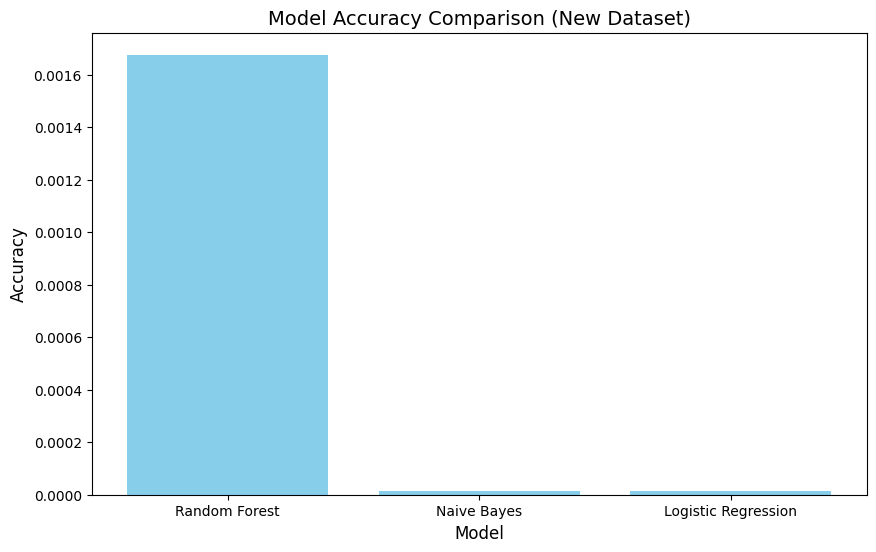

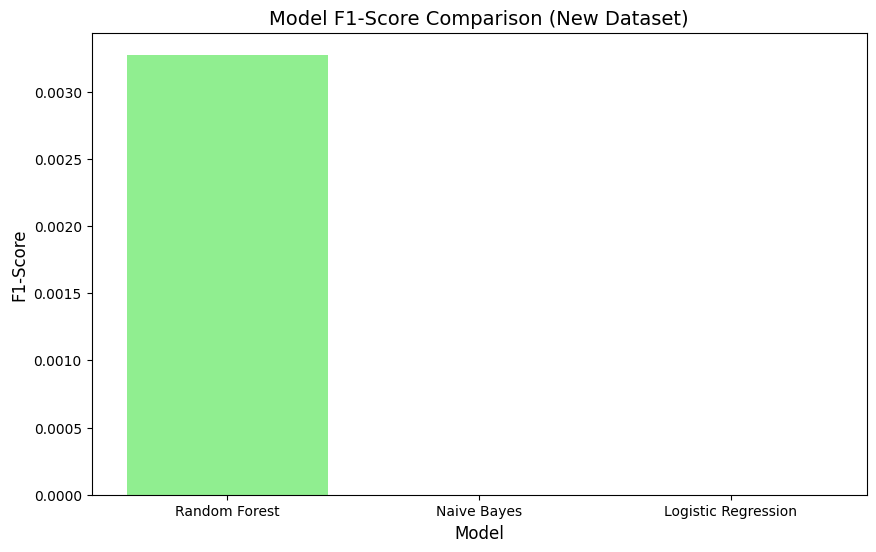

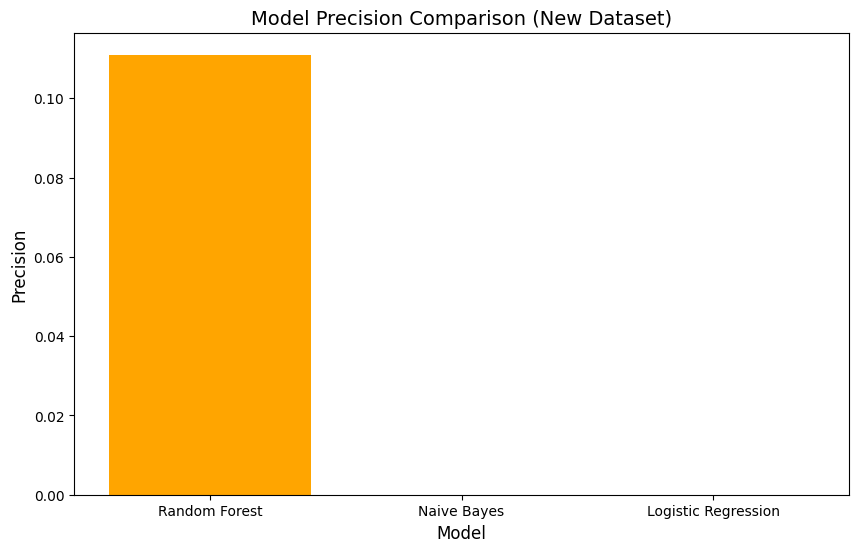

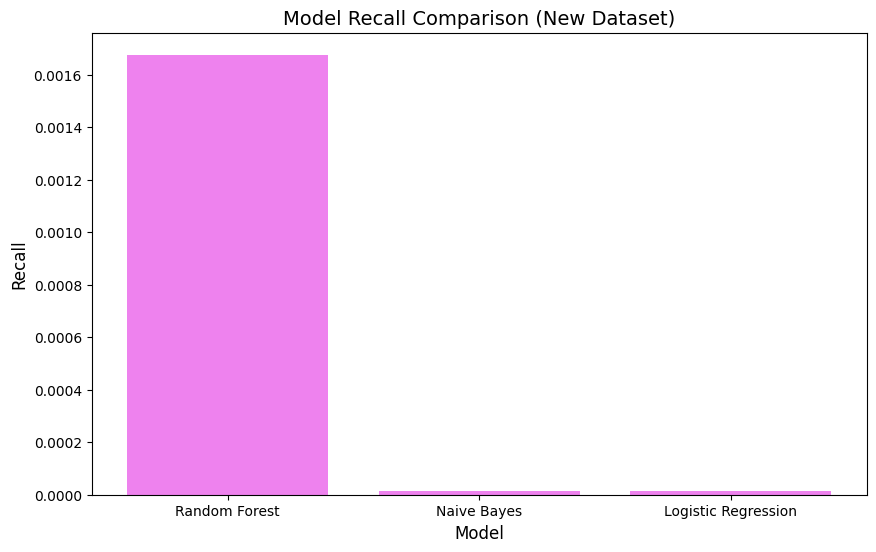

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["Accuracy"], color='skyblue')
plt.title("Model Accuracy Comparison (New Dataset)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.show()

plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["F1-Score"], color='lightgreen')
plt.title("Model F1-Score Comparison (New Dataset)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.show()

plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["Precision"], color='orange')
plt.title("Model Precision Comparison (New Dataset)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.show()

plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["Recall"], color='violet')
plt.title("Model Recall Comparison (New Dataset)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.show()

In [ ]:
!pip install streamlit pyngrok --quiet


In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd

# -----------------------------
# Load saved models and vectorizer
# -----------------------------
st.title("🚨 911 Emergency Call Category Classifier")

st.write("This app predicts whether a 911 call is related to **EMS**, **Fire**, or **Traffic** using pre-trained models.")

# Load models
vectorizer = joblib.load("saved_models/tfidf_vectorizer.joblib")
models = {
    "Naive Bayes": joblib.load("saved_models/naive_bayes.joblib"),
    "Logistic Regression": joblib.load("saved_models/logistic_regression.joblib"),
    "Random Forest": joblib.load("saved_models/random_forest.joblib")
}

# -----------------------------
# Text input from user
# -----------------------------
user_input = st.text_area("Enter 911 call title or description:",
                          "EMS: BACK PAINS/INJURY")

if st.button("🔍 Predict Category"):
    if user_input.strip():
        # Transform text using the same TF-IDF vectorizer
        X_new = vectorizer.transform([user_input])

        # Store results from each model
        results = {}
        for name, model in models.items():
            pred = model.predict(X_new)[0]
            results[name] = pred

        # Display results
        st.subheader("📊 Prediction Results:")
        for model_name, prediction in results.items():
            st.write(f"**{model_name}** → Predicted Category: `{prediction}`")

    else:
        st.warning("Please enter a 911 call title or description.")


Writing app.py


In [77]:
!ngrok authtoken 34vdrJkUapN1XpbIi2LVkRwUYEn_uFygwBnPdeFgvf5S8r6r


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [78]:
from pyngrok import ngrok
import threading
import os

!kill -9 $(lsof -t -i:8501) 2>/dev/null || true

def run_app():
    os.system("streamlit run app.py --server.port 8501")

thread = threading.Thread(target=run_app)
thread.start()

public_url = ngrok.connect(addr=8501)
print("🚀 Streamlit App URL:", public_url)


🚀 Streamlit App URL: NgrokTunnel: "https://dave-lated-inspectingly.ngrok-free.dev" -> "http://localhost:8501"
